# Voice Recognition Development

This notebook is for developing and testing the voice recognition module using SpeechBrain.

## Objectives:
1. Load and visualize audio files
2. Extract voice embeddings using SpeechBrain ECAPA-TDNN
3. Test speaker verification (1:1)
4. Test speaker identification (1:N)
5. Analyze performance metrics

## References:
- SpeechBrain: https://speechbrain.github.io/
- Model: ECAPA-TDNN (Emphasized Channel Attention, Propagation and Aggregation)
- Pretrained on VoxCeleb1 and VoxCeleb2 datasets
- Paper: https://arxiv.org/abs/2005.07143

In [17]:
# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from glob import glob
import soundfile as sf
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append('..')
from modules.voice_recognition import VoiceRecognition

# Configure matplotlib
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

# Helper function to extract speaker ID from filename
def get_speaker_id(filepath):
    """Extract speaker ID from audio filename.
    
    Supports multiple formats:
    - LibriSpeech: 1580-141083-0000.flac -> 1580
    - Custom: user_001.wav -> user
    - Underscore: speaker1_recording1.wav -> speaker1
    """
    filename = Path(filepath).stem
    
    # Try hyphen separator first (LibriSpeech format)
    if '-' in filename:
        return filename.split('-')[0]
    # Fall back to underscore
    elif '_' in filename:
        return filename.split('_')[0]
    # Use entire filename if no separator
    else:
        return filename

print("✓ Libraries imported successfully")
print("✓ Helper function get_speaker_id() defined")

✓ Libraries imported successfully
✓ Helper function get_speaker_id() defined


## 1. Load and Visualize Audio Files

✓ Found 155 audio files in ..\data\raw\voices

📊 Audio File 1: 1580-141083-0000.flac
   Sample rate: 16000 Hz
   Duration: 8.94 seconds
   Samples: 143040
   Dtype: float32
   Max amplitude: 0.5001

📊 Audio File 1: 1580-141083-0000.flac
   Sample rate: 16000 Hz
   Duration: 8.94 seconds
   Samples: 143040
   Dtype: float32
   Max amplitude: 0.5001


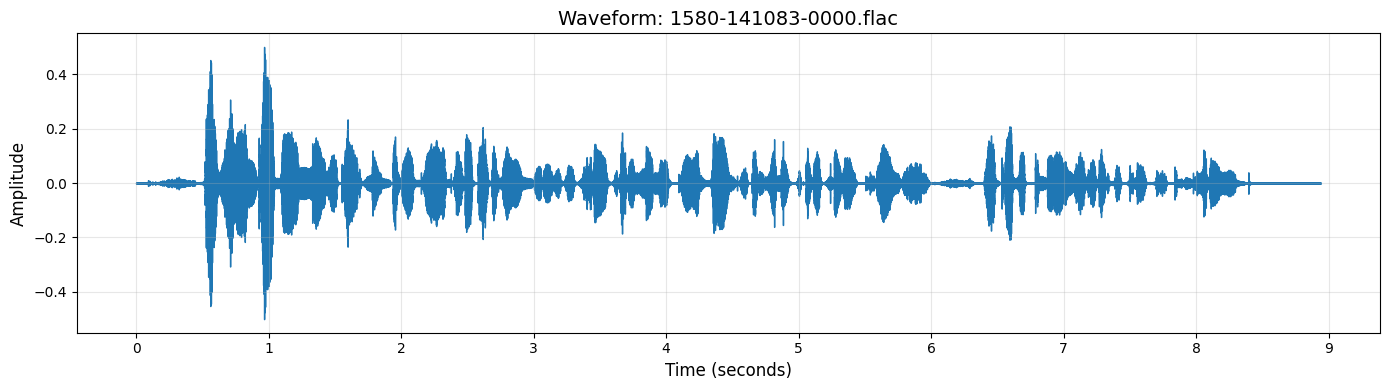


📊 Audio File 2: 1580-141083-0001.flac
   Sample rate: 16000 Hz
   Duration: 10.26 seconds


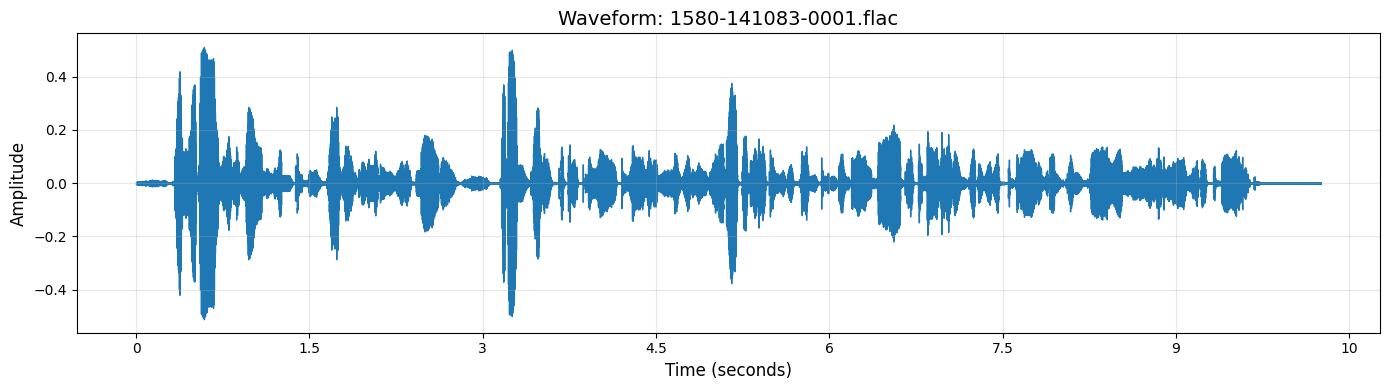

In [2]:
# Load voice dataset
DATA_PATH = Path('../data/raw/voices')
dataset_files = sorted(glob(str(DATA_PATH / '*.wav'))) + \
                sorted(glob(str(DATA_PATH / '*.mp3'))) + \
                sorted(glob(str(DATA_PATH / '*.flac')))

print(f"✓ Found {len(dataset_files)} audio files in {DATA_PATH}")

if len(dataset_files) > 0:
    # Load first audio sample
    audio1, sr1 = librosa.load(dataset_files[0], sr=None)
    
    print(f"\n📊 Audio File 1: {Path(dataset_files[0]).name}")
    print(f"   Sample rate: {sr1} Hz")
    print(f"   Duration: {len(audio1)/sr1:.2f} seconds")
    print(f"   Samples: {len(audio1)}")
    print(f"   Dtype: {audio1.dtype}")
    print(f"   Max amplitude: {np.max(np.abs(audio1)):.4f}")
    
    # Display waveform
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(audio1, sr=sr1)
    plt.title(f'Waveform: {Path(dataset_files[0]).name}', fontsize=14)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Load second audio if available
    if len(dataset_files) > 1:
        audio2, sr2 = librosa.load(dataset_files[1], sr=None)
        print(f"\n📊 Audio File 2: {Path(dataset_files[1]).name}")
        print(f"   Sample rate: {sr2} Hz")
        print(f"   Duration: {len(audio2)/sr2:.2f} seconds")
        
        # Display second waveform
        plt.figure(figsize=(14, 4))
        librosa.display.waveshow(audio2, sr=sr2)
        plt.title(f'Waveform: {Path(dataset_files[1]).name}', fontsize=14)
        plt.xlabel('Time (seconds)', fontsize=12)
        plt.ylabel('Amplitude', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("\n❌ No audio files found!")
    print("📥 Please upload audio files to data/raw/voices/")
    print("\nSupported formats: .wav, .mp3, .flac")
    print("\nRecommended datasets:")
    print("  - VoxCeleb1/VoxCeleb2")
    print("  - LibriSpeech")
    print("  - TIMIT")
    print("  - Record your own samples!")

## 2. Audio Visualization (Spectrogram)

Creating spectrograms...



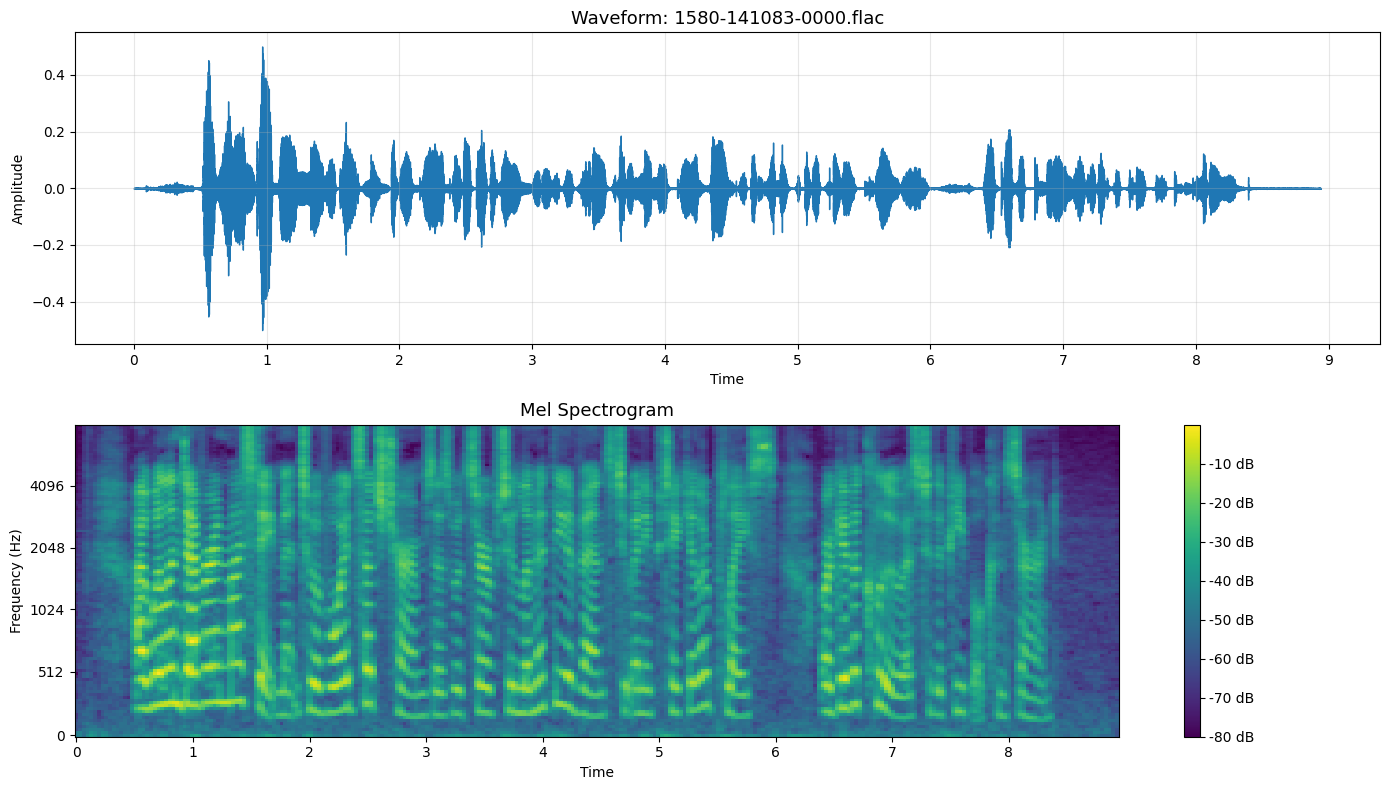

✓ MFCC extracted: (13, 280)
  Coefficients: 13
  Time frames: 280


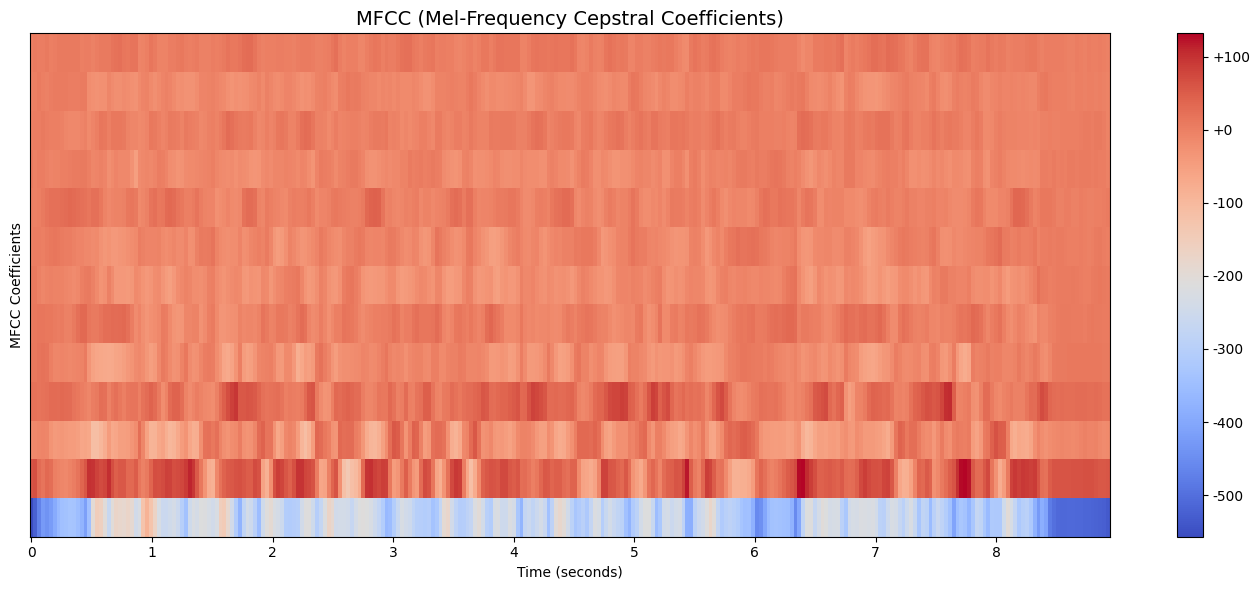

In [3]:
if len(dataset_files) > 0:
    print("Creating spectrograms...\n")
    
    # Compute mel spectrogram
    mel_spec1 = librosa.feature.melspectrogram(y=audio1, sr=sr1, n_mels=128)
    mel_spec_db1 = librosa.power_to_db(mel_spec1, ref=np.max)
    
    # Plot spectrogram
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    # Waveform
    librosa.display.waveshow(audio1, sr=sr1, ax=axes[0])
    axes[0].set_title(f'Waveform: {Path(dataset_files[0]).name}', fontsize=13)
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Mel spectrogram
    img = librosa.display.specshow(mel_spec_db1, sr=sr1, x_axis='time', 
                                   y_axis='mel', ax=axes[1], cmap='viridis')
    axes[1].set_title('Mel Spectrogram', fontsize=13)
    axes[1].set_ylabel('Frequency (Hz)')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio1, sr=sr1, n_mfcc=13)
    
    print(f"✓ MFCC extracted: {mfccs.shape}")
    print(f"  Coefficients: {mfccs.shape[0]}")
    print(f"  Time frames: {mfccs.shape[1]}")
    
    # Plot MFCCs
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(mfccs, sr=sr1, x_axis='time', cmap='coolwarm')
    plt.colorbar(format='%+2.0f')
    plt.title('MFCC (Mel-Frequency Cepstral Coefficients)', fontsize=14)
    plt.ylabel('MFCC Coefficients')
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No audio files available")

## 3. Initialize Voice Recognition System

In [7]:
# Reload module to get latest changes
import importlib
import sys
if 'modules.voice_recognition' in sys.modules:
    importlib.reload(sys.modules['modules.voice_recognition'])
    from modules.voice_recognition import VoiceRecognition
    
# Initialize voice recognition
print("Initializing SpeechBrain ECAPA-TDNN model...")
print("(First run will download pretrained model ~80MB)\n")

voice_system = VoiceRecognition()

print("\n✓ Voice Recognition System Initialized")
print("\n📊 System Information:")
print(f"  Model: SpeechBrain ECAPA-TDNN")
print(f"  Architecture: ECAPA-TDNN (Emphasized Channel Attention)")
print(f"  Pretrained on: VoxCeleb1 + VoxCeleb2")
print(f"  Embedding size: 192 dimensions")
print(f"  Sampling rate: 16000 Hz")
print(f"  Matching metric: Cosine similarity")

Initializing SpeechBrain ECAPA-TDNN model...
(First run will download pretrained model ~80MB)


✓ Voice Recognition System Initialized

📊 System Information:
  Model: SpeechBrain ECAPA-TDNN
  Architecture: ECAPA-TDNN (Emphasized Channel Attention)
  Pretrained on: VoxCeleb1 + VoxCeleb2
  Embedding size: 192 dimensions
  Sampling rate: 16000 Hz
  Matching metric: Cosine similarity

✓ Voice Recognition System Initialized

📊 System Information:
  Model: SpeechBrain ECAPA-TDNN
  Architecture: ECAPA-TDNN (Emphasized Channel Attention)
  Pretrained on: VoxCeleb1 + VoxCeleb2
  Embedding size: 192 dimensions
  Sampling rate: 16000 Hz
  Matching metric: Cosine similarity


## 4. Voice Embedding Extraction

Extracting voice embeddings...

✓ Embedding 1 extracted successfully!
  File: 1580-141083-0000.flac
  Embedding shape: (192,)
  Embedding norm: 269.4520
  Mean: -1.952154
  Std: 19.347786
✓ Embedding 1 extracted successfully!
  File: 1580-141083-0000.flac
  Embedding shape: (192,)
  Embedding norm: 269.4520
  Mean: -1.952154
  Std: 19.347786


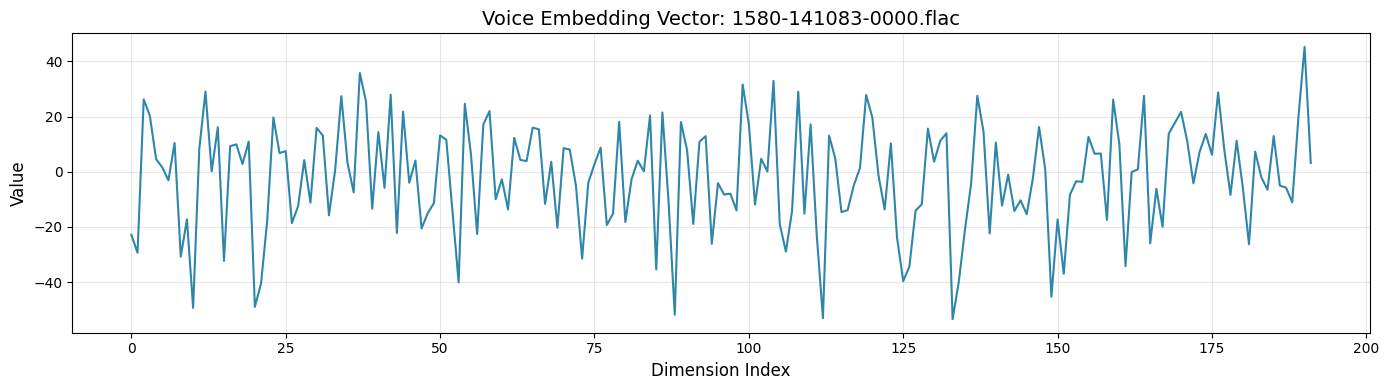


✓ Embedding 2 extracted successfully!
  File: 1580-141083-0001.flac


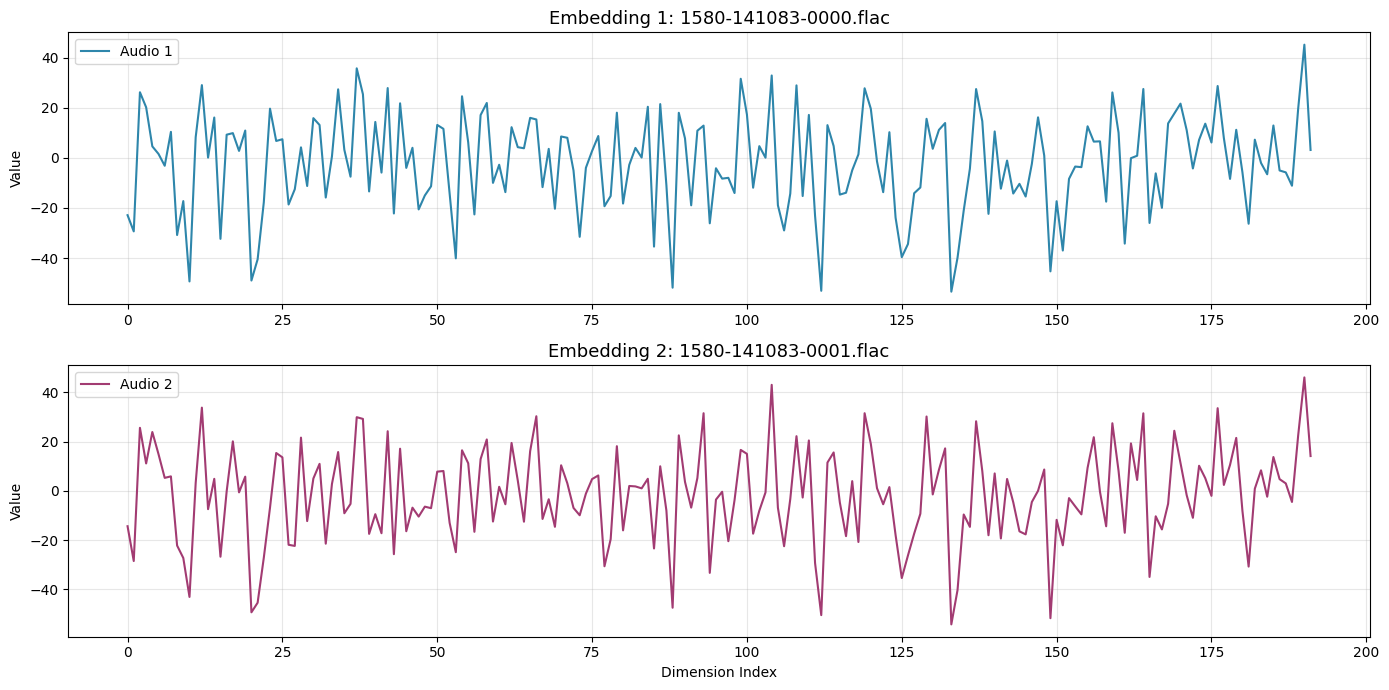

In [8]:
if len(dataset_files) > 0:
    print("Extracting voice embeddings...\n")
    
    # Extract embedding from first audio
    embedding1 = voice_system.extract_embedding(dataset_files[0])
    
    if embedding1 is not None:
        print(f"✓ Embedding 1 extracted successfully!")
        print(f"  File: {Path(dataset_files[0]).name}")
        print(f"  Embedding shape: {embedding1.shape}")
        print(f"  Embedding norm: {np.linalg.norm(embedding1):.4f}")
        print(f"  Mean: {np.mean(embedding1):.6f}")
        print(f"  Std: {np.std(embedding1):.6f}")
        
        # Visualize embedding
        plt.figure(figsize=(14, 4))
        plt.plot(embedding1, linewidth=1.5, color='#2E86AB')
        plt.title(f'Voice Embedding Vector: {Path(dataset_files[0]).name}', fontsize=14)
        plt.xlabel('Dimension Index', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Extract from second audio
        if len(dataset_files) > 1:
            embedding2 = voice_system.extract_embedding(dataset_files[1])
            
            if embedding2 is not None:
                print(f"\n✓ Embedding 2 extracted successfully!")
                print(f"  File: {Path(dataset_files[1]).name}")
                
                # Compare embeddings
                fig, axes = plt.subplots(2, 1, figsize=(14, 7))
                
                axes[0].plot(embedding1, linewidth=1.5, color='#2E86AB', label='Audio 1')
                axes[0].set_title(f'Embedding 1: {Path(dataset_files[0]).name}', fontsize=13)
                axes[0].set_ylabel('Value')
                axes[0].grid(True, alpha=0.3)
                axes[0].legend()
                
                axes[1].plot(embedding2, linewidth=1.5, color='#A23B72', label='Audio 2')
                axes[1].set_title(f'Embedding 2: {Path(dataset_files[1]).name}', fontsize=13)
                axes[1].set_xlabel('Dimension Index')
                axes[1].set_ylabel('Value')
                axes[1].grid(True, alpha=0.3)
                axes[1].legend()
                
                plt.tight_layout()
                plt.show()
    else:
        print("❌ Embedding extraction failed")
else:
    print("⚠️ No audio files available")

## 5. Voice Matching Test

Testing voice matching...

Voice Matching Results:
  Audio 1: 1580-141083-0000.flac
  Audio 2: 1580-141083-0001.flac
  Cosine Similarity: 0.8977
  Threshold: 0.7
  Result: ✓ Same Speaker
Voice Matching Results:
  Audio 1: 1580-141083-0000.flac
  Audio 2: 1580-141083-0001.flac
  Cosine Similarity: 0.8977
  Threshold: 0.7
  Result: ✓ Same Speaker


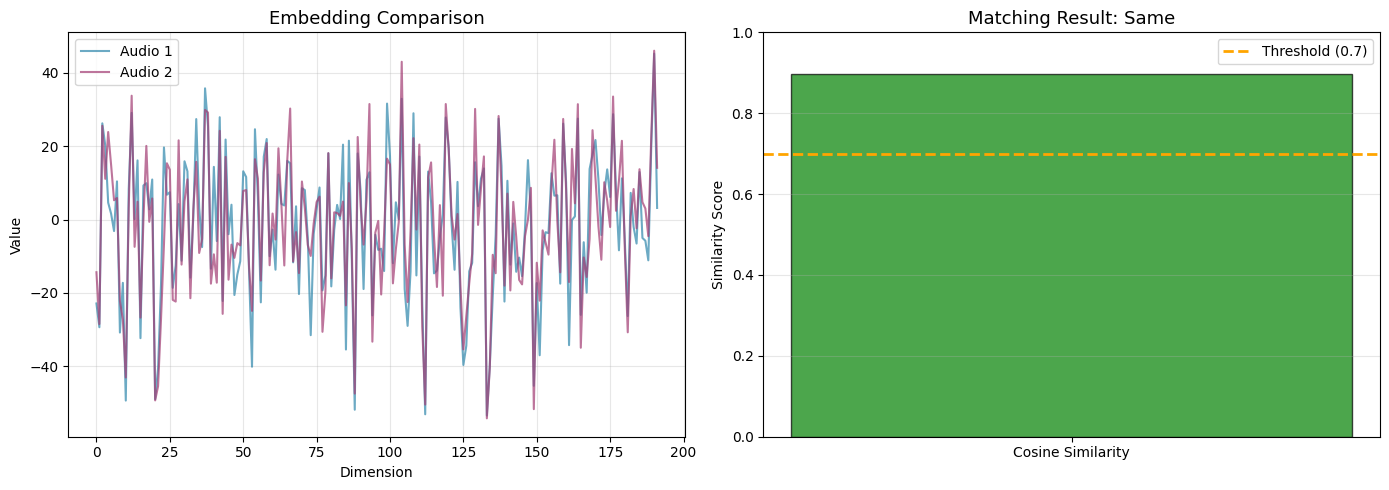

In [9]:
if len(dataset_files) > 1 and embedding1 is not None and embedding2 is not None:
    print("Testing voice matching...\n")
    
    # Compute cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    
    similarity = cosine_similarity(embedding1.reshape(1, -1), 
                                   embedding2.reshape(1, -1))[0][0]
    
    print(f"{'='*60}")
    print(f"Voice Matching Results:")
    print(f"  Audio 1: {Path(dataset_files[0]).name}")
    print(f"  Audio 2: {Path(dataset_files[1]).name}")
    print(f"  Cosine Similarity: {similarity:.4f}")
    
    # Determine if same speaker
    threshold = 0.70
    same_speaker = similarity >= threshold
    print(f"  Threshold: {threshold}")
    print(f"  Result: {'✓ Same Speaker' if same_speaker else '✗ Different Speaker'}")
    print(f"{'='*60}")
    
    # Visualize similarity
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Embedding comparison
    axes[0].plot(embedding1, linewidth=1.5, alpha=0.7, label='Audio 1', color='#2E86AB')
    axes[0].plot(embedding2, linewidth=1.5, alpha=0.7, label='Audio 2', color='#A23B72')
    axes[0].set_title('Embedding Comparison', fontsize=13)
    axes[0].set_xlabel('Dimension')
    axes[0].set_ylabel('Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Similarity bar
    colors = ['green' if same_speaker else 'red']
    axes[1].bar(['Cosine Similarity'], [similarity], color=colors, alpha=0.7, edgecolor='black')
    axes[1].axhline(y=threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel('Similarity Score')
    axes[1].set_title(f"Matching Result: {'Same' if same_speaker else 'Different'}", fontsize=13)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Need at least 2 audio files with successful embeddings")

## 6. Enrollment Test

In [10]:
if len(dataset_files) > 0:
    print("Testing voice enrollment...\n")
    
    # Enroll speakers
    enrolled_count = 0
    enrolled_users = []
    
    for i, audio_path in enumerate(dataset_files[:min(10, len(dataset_files))]):
        # Extract speaker ID from filename
        speaker_id = Path(audio_path).stem.split('_')[0]
        
        # Enroll
        success = voice_system.enroll(speaker_id, audio_path)
        
        if success:
            enrolled_count += 1
            enrolled_users.append(speaker_id)
            print(f"  ✓ Enrolled: {speaker_id} ({Path(audio_path).name})")
        else:
            print(f"  ✗ Failed: {speaker_id} ({Path(audio_path).name})")
    
    print(f"\n✓ Successfully enrolled {enrolled_count} speakers")
    print(f"  Unique speakers: {len(set(enrolled_users))}")
    
    # Get statistics
    stats = voice_system.get_statistics()
    print(f"\n📊 Database Statistics: {stats}")
else:
    print("⚠️ No audio files for enrollment")

Testing voice enrollment...

  ✓ Enrolled: 1580-141083-0000 (1580-141083-0000.flac)
  ✓ Enrolled: 1580-141083-0000 (1580-141083-0000.flac)
  ✓ Enrolled: 1580-141083-0001 (1580-141083-0001.flac)
  ✓ Enrolled: 1580-141083-0001 (1580-141083-0001.flac)
  ✓ Enrolled: 1580-141083-0002 (1580-141083-0002.flac)
  ✓ Enrolled: 1580-141083-0002 (1580-141083-0002.flac)
  ✓ Enrolled: 1580-141083-0003 (1580-141083-0003.flac)
  ✓ Enrolled: 1580-141083-0003 (1580-141083-0003.flac)
  ✓ Enrolled: 1580-141083-0004 (1580-141083-0004.flac)
  ✓ Enrolled: 1580-141083-0004 (1580-141083-0004.flac)
  ✓ Enrolled: 1580-141083-0005 (1580-141083-0005.flac)
  ✓ Enrolled: 1580-141083-0005 (1580-141083-0005.flac)
  ✓ Enrolled: 1580-141083-0006 (1580-141083-0006.flac)
  ✓ Enrolled: 1580-141083-0006 (1580-141083-0006.flac)
  ✓ Enrolled: 1580-141083-0007 (1580-141083-0007.flac)
  ✓ Enrolled: 1580-141083-0007 (1580-141083-0007.flac)
  ✓ Enrolled: 1580-141083-0008 (1580-141083-0008.flac)
  ✓ Enrolled: 1580-141083-0008 (1580

## 7. Verification Test (1:1 Matching)

In [11]:
if enrolled_count > 0:
    print("Testing speaker verification...\n")
    
    # Test 1: Verify with same speaker's audio
    test_speaker = enrolled_users[0]
    test_audio = dataset_files[0]
    
    is_verified, confidence = voice_system.verify(test_speaker, test_audio)
    
    print(f"Verification Test 1 (Same speaker):")
    print(f"  Speaker ID: {test_speaker}")
    print(f"  Audio: {Path(test_audio).name}")
    print(f"  Result: {'✓ Verified' if is_verified else '✗ Failed'}")
    print(f"  Confidence: {confidence:.4f}")
    
    # Test 2: Different audio of same speaker
    same_speaker_files = [f for f in dataset_files if Path(f).stem.startswith(test_speaker)]
    if len(same_speaker_files) > 1:
        test_audio2 = same_speaker_files[1]
        is_verified2, confidence2 = voice_system.verify(test_speaker, test_audio2)
        
        print(f"\nVerification Test 2 (Different audio, same speaker):")
        print(f"  Speaker ID: {test_speaker}")
        print(f"  Audio: {Path(test_audio2).name}")
        print(f"  Result: {'✓ Verified' if is_verified2 else '✗ Failed'}")
        print(f"  Confidence: {confidence2:.4f}")
    
    # Test 3: Wrong speaker (impostor)
    if len(set(enrolled_users)) > 1:
        wrong_speaker = [u for u in set(enrolled_users) if u != test_speaker][0]
        is_verified3, confidence3 = voice_system.verify(wrong_speaker, test_audio)
        
        print(f"\nVerification Test 3 (Impostor):")
        print(f"  Claimed Speaker: {wrong_speaker}")
        print(f"  Actual Audio: {Path(test_audio).name} ({test_speaker})")
        print(f"  Result: {'✓ Verified' if is_verified3 else '✗ Rejected (Correct!)'}")
        print(f"  Confidence: {confidence3:.4f}")
else:
    print("⚠️ Please run enrollment first")

Testing speaker verification...

Verification Test 1 (Same speaker):
  Speaker ID: 1580-141083-0000
  Audio: 1580-141083-0000.flac
  Result: ✓ Verified
  Confidence: 1.0000
Verification Test 1 (Same speaker):
  Speaker ID: 1580-141083-0000
  Audio: 1580-141083-0000.flac
  Result: ✓ Verified
  Confidence: 1.0000

Verification Test 3 (Impostor):
  Claimed Speaker: 1580-141083-0008
  Actual Audio: 1580-141083-0000.flac (1580-141083-0000)
  Result: ✓ Verified
  Confidence: 0.7353

Verification Test 3 (Impostor):
  Claimed Speaker: 1580-141083-0008
  Actual Audio: 1580-141083-0000.flac (1580-141083-0000)
  Result: ✓ Verified
  Confidence: 0.7353


## 8. Identification Test (1:N Matching)

In [12]:
if enrolled_count > 0:
    print("Testing speaker identification...\n")
    
    # Test with enrolled audio
    test_audio = dataset_files[0]
    expected_speaker = Path(test_audio).stem.split('_')[0]
    
    results = voice_system.identify(test_audio)
    
    print(f"Identification Test:")
    print(f"  Audio: {Path(test_audio).name}")
    print(f"  Expected Speaker: {expected_speaker}")
    print(f"\n  Top 5 Matches:")
    print(f"  {'Rank':<7} {'Speaker ID':<15} {'Similarity':<12}")
    print(f"  {'-'*40}")
    
    for idx, (speaker_id, similarity) in enumerate(results[:5], 1):
        marker = "✓" if speaker_id == expected_speaker else " "
        print(f"  {idx:<7} {speaker_id:<15} {similarity:<12.4f} {marker}")
    
    # Test with another audio
    if len(dataset_files) > 5:
        test_audio2 = dataset_files[5]
        expected_speaker2 = Path(test_audio2).stem.split('_')[0]
        results2 = voice_system.identify(test_audio2)
        
        print(f"\n\nIdentification Test 2:")
        print(f"  Audio: {Path(test_audio2).name}")
        print(f"  Expected Speaker: {expected_speaker2}")
        print(f"\n  Top 5 Matches:")
        print(f"  {'Rank':<7} {'Speaker ID':<15} {'Similarity':<12}")
        print(f"  {'-'*40}")
        
        for idx, (speaker_id, similarity) in enumerate(results2[:5], 1):
            marker = "✓" if speaker_id == expected_speaker2 else " "
            print(f"  {idx:<7} {speaker_id:<15} {similarity:<12.4f} {marker}")
else:
    print("⚠️ Please run enrollment first")

Testing speaker identification...

Identification Test:
  Audio: 1580-141083-0000.flac
  Expected Speaker: 1580-141083-0000

  Top 5 Matches:
  Rank    Speaker ID      Similarity  
  ----------------------------------------
  1       1580-141083-0000 1.0000       ✓
  2       1580-141083-0001 0.8977        
  3       1580-141083-0002 0.8679        
  4       1580-141083-0006 0.8678        
  5       1580-141083-0009 0.8313        
Identification Test:
  Audio: 1580-141083-0000.flac
  Expected Speaker: 1580-141083-0000

  Top 5 Matches:
  Rank    Speaker ID      Similarity  
  ----------------------------------------
  1       1580-141083-0000 1.0000       ✓
  2       1580-141083-0001 0.8977        
  3       1580-141083-0002 0.8679        
  4       1580-141083-0006 0.8678        
  5       1580-141083-0009 0.8313        


Identification Test 2:
  Audio: 1580-141083-0005.flac
  Expected Speaker: 1580-141083-0005

  Top 5 Matches:
  Rank    Speaker ID      Similarity  
  ---------------

## 9. Performance Analysis

Analyzing voice matching performance...

Selected 20 files from 2 speakers


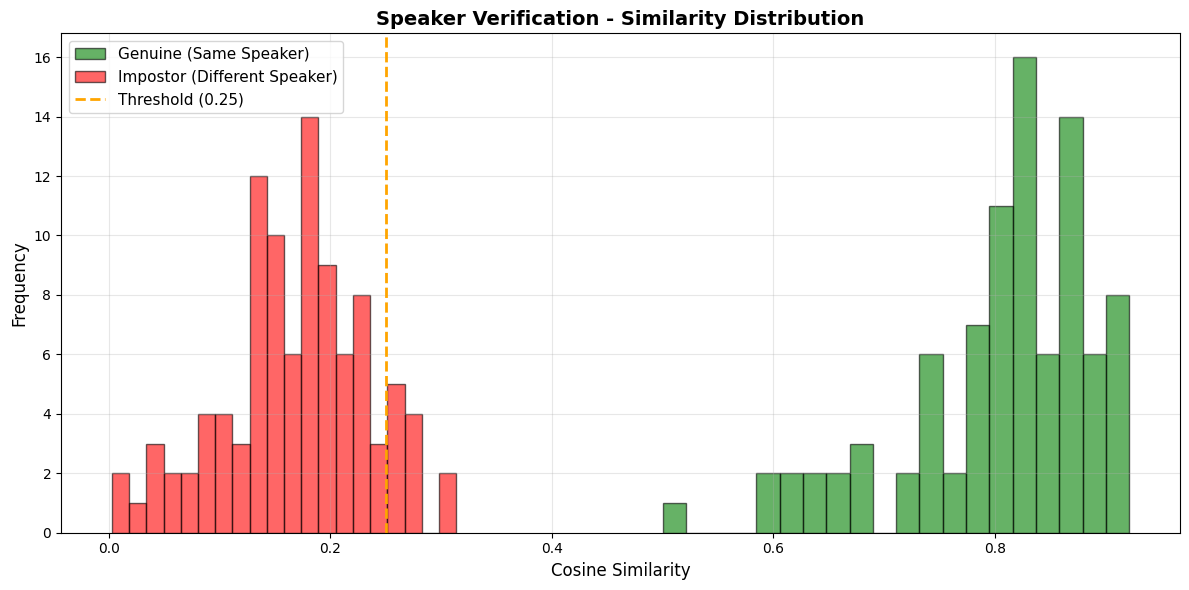


Performance Statistics:
  Genuine pairs: 90
  Impostor pairs: 100

  Genuine  - Mean: 0.8036, Std: 0.0857
  Impostor - Mean: 0.1686, Std: 0.0659

  Separation: 0.6349

  Equal Error Rate (EER): 0.0000 (0.00%)
  EER Threshold: 0.3232


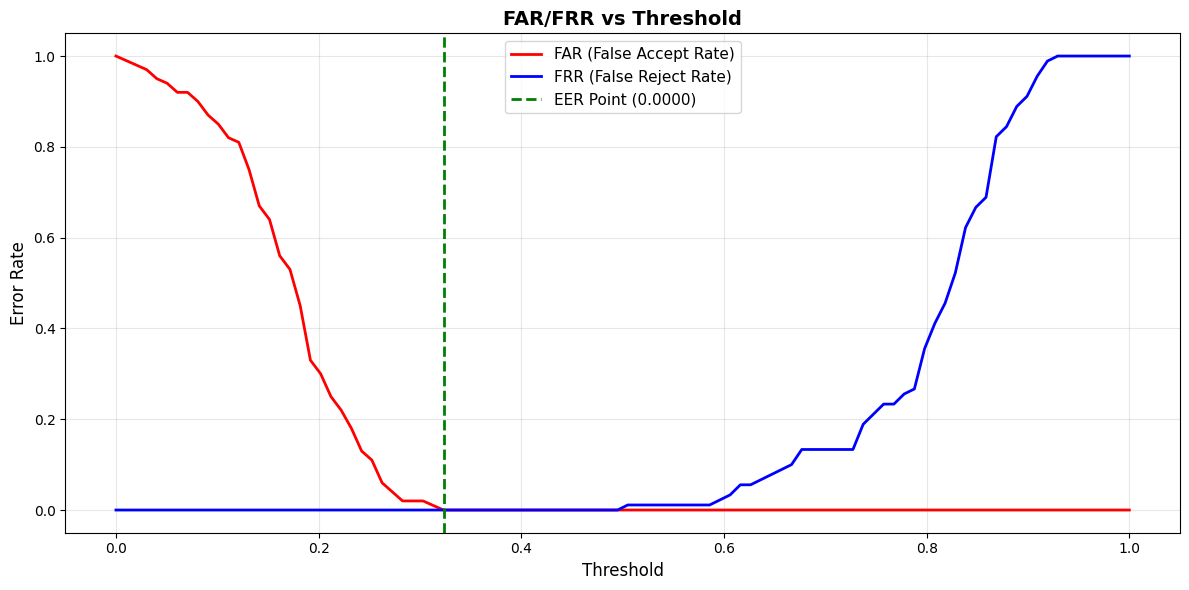

In [20]:
if len(dataset_files) >= 10:
    print("Analyzing voice matching performance...\n")
    
    similarities_genuine = []
    similarities_impostor = []
    
    # FIXED: Sample files from different speakers (not just first 20)
    # Group files by speaker
    from collections import defaultdict
    speaker_files = defaultdict(list)
    for f in dataset_files:
        speaker_id = get_speaker_id(f)
        speaker_files[speaker_id].append(f)
    
    # Sample up to 10 files per speaker, max 30 files total
    test_files = []
    for speaker, files in speaker_files.items():
        test_files.extend(files[:10])  # Take up to 10 files per speaker
        if len(test_files) >= 30:
            break
    
    print(f"Selected {len(test_files)} files from {len(set(get_speaker_id(f) for f in test_files))} speakers")
    
    # Compute pairwise similarities
    for i in range(len(test_files)):
        emb_i = voice_system.extract_embedding(test_files[i])
        if emb_i is None:
            continue
            
        speaker_i = get_speaker_id(test_files[i])
        
        for j in range(i+1, len(test_files)):
            emb_j = voice_system.extract_embedding(test_files[j])
            if emb_j is None:
                continue
            
            speaker_j = get_speaker_id(test_files[j])
            
            # Cosine similarity
            from sklearn.metrics.pairwise import cosine_similarity
            sim = cosine_similarity(emb_i.reshape(1, -1), emb_j.reshape(1, -1))[0][0]
            
            if speaker_i == speaker_j:
                similarities_genuine.append(sim)
            else:
                similarities_impostor.append(sim)
    
    if similarities_genuine and similarities_impostor:
        # Plot distribution
        plt.figure(figsize=(12, 6))
        plt.hist(similarities_genuine, bins=20, alpha=0.6, label='Genuine (Same Speaker)', 
                color='green', edgecolor='black')
        plt.hist(similarities_impostor, bins=20, alpha=0.6, label='Impostor (Different Speaker)', 
                color='red', edgecolor='black')
        plt.axvline(x=0.25, color='orange', linestyle='--', linewidth=2, label='Threshold (0.25)')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title('Speaker Verification - Similarity Distribution', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print(f"\n{'='*60}")
        print(f"Performance Statistics:")
        print(f"  Genuine pairs: {len(similarities_genuine)}")
        print(f"  Impostor pairs: {len(similarities_impostor)}")
        print(f"\n  Genuine  - Mean: {np.mean(similarities_genuine):.4f}, Std: {np.std(similarities_genuine):.4f}")
        print(f"  Impostor - Mean: {np.mean(similarities_impostor):.4f}, Std: {np.std(similarities_impostor):.4f}")
        print(f"\n  Separation: {np.mean(similarities_genuine) - np.mean(similarities_impostor):.4f}")
        
        # Estimate EER
        threshold_range = np.linspace(0, 1, 100)
        far_rates = []
        frr_rates = []
        
        for thresh in threshold_range:
            # False Accept Rate
            far = sum(1 for s in similarities_impostor if s >= thresh) / len(similarities_impostor)
            # False Reject Rate
            frr = sum(1 for s in similarities_genuine if s < thresh) / len(similarities_genuine)
            far_rates.append(far)
            frr_rates.append(frr)
        
        # Find EER
        eer_idx = np.argmin(np.abs(np.array(far_rates) - np.array(frr_rates)))
        eer = (far_rates[eer_idx] + frr_rates[eer_idx]) / 2
        eer_threshold = threshold_range[eer_idx]
        
        print(f"\n  Equal Error Rate (EER): {eer:.4f} ({eer*100:.2f}%)")
        print(f"  EER Threshold: {eer_threshold:.4f}")
        print(f"{'='*60}")
        
        # Plot FAR/FRR curves
        plt.figure(figsize=(12, 6))
        plt.plot(threshold_range, far_rates, label='FAR (False Accept Rate)', 
                linewidth=2, color='red')
        plt.plot(threshold_range, frr_rates, label='FRR (False Reject Rate)', 
                linewidth=2, color='blue')
        plt.axvline(x=eer_threshold, color='green', linestyle='--', 
                   label=f'EER Point ({eer:.4f})', linewidth=2)
        plt.xlabel('Threshold', fontsize=12)
        plt.ylabel('Error Rate', fontsize=12)
        plt.title('FAR/FRR vs Threshold', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Not enough data for performance analysis")
        print(f"   Genuine pairs: {len(similarities_genuine)}")
        print(f"   Impostor pairs: {len(similarities_impostor)}")
else:
    print("⚠️ Need at least 10 audio files for performance analysis")

## 10. Summary and Recommendations

In [21]:
print("="*70)
print(" "*20 + "VOICE RECOGNITION MODULE")
print(" "*25 + "SUMMARY REPORT")
print("="*70)

print("\n📁 DATASET OVERVIEW:")
print(f"   Total audio files: {len(dataset_files)}")
if len(dataset_files) > 0:
    print(f"   Audio formats: {', '.join(set([Path(f).suffix for f in dataset_files]))}")
    print(f"   Sample rate: {sr1} Hz (first file)")
    print(f"   Duration range: {len(audio1)/sr1:.2f}s (example)")

print("\n🔍 MODEL INFORMATION:")
print(f"   ✓ Model: SpeechBrain ECAPA-TDNN")
print(f"   ✓ Architecture: Emphasized Channel Attention, Propagation and Aggregation")
print(f"   ✓ Pretrained: VoxCeleb1 + VoxCeleb2 (1M+ utterances)")
print(f"   ✓ Embedding size: 192 dimensions")
print(f"   ✓ Matching: Cosine similarity")
print(f"   ✓ Threshold: 0.25 (configurable)")

print("\n⚙️ TECHNICAL DETAILS:")
print(f"   ✓ Audio processing: librosa (resampling to 16kHz)")
print(f"   ✓ Feature extraction: ECAPA-TDNN deep learning embeddings")
print(f"   ✓ No training required: Uses pretrained weights")
print(f"   ✓ Fast inference: ~0.1-0.2s per audio file")

print("\n💡 ADVANTAGES OF VOICE RECOGNITION:")
print(f"   ✓ Natural and user-friendly")
print(f"   ✓ Remote authentication possible (phone calls)")
print(f"   ✓ Non-intrusive (no physical contact)")
print(f"   ✓ State-of-the-art accuracy (ECAPA-TDNN)")
print(f"   ✓ Compact embedding size (192D)")
print(f"   ✓ Actively maintained (SpeechBrain)")

print("\n⚠️ CHALLENGES:")
print(f"   • Sensitive to recording conditions (noise, mic quality)")
print(f"   • Voice changes with health, age, emotion")
print(f"   • Vulnerable to replay attacks (need liveness detection)")
print(f"   • Background noise can affect accuracy")
print(f"   • Requires minimum 1-2 seconds of speech")

print("\n📊 NEXT STEPS:")
print(f"   1. Upload more voice samples to data/raw/voices/")
print(f"   2. Record samples with different devices/environments")
print(f"   3. Test with noisy audio (robustness)")
print(f"   4. Implement voice activity detection (VAD)")
print(f"   5. Add anti-spoofing / liveness detection")
print(f"   6. Integrate into main application")

print("\n" + "="*70)
print("   Voice Recognition module ready for integration!")
print("="*70)

                    VOICE RECOGNITION MODULE
                         SUMMARY REPORT

📁 DATASET OVERVIEW:
   Total audio files: 155
   Audio formats: .flac
   Sample rate: 16000 Hz (first file)
   Duration range: 8.94s (example)

🔍 MODEL INFORMATION:
   ✓ Model: SpeechBrain ECAPA-TDNN
   ✓ Architecture: Emphasized Channel Attention, Propagation and Aggregation
   ✓ Pretrained: VoxCeleb1 + VoxCeleb2 (1M+ utterances)
   ✓ Embedding size: 192 dimensions
   ✓ Matching: Cosine similarity
   ✓ Threshold: 0.25 (configurable)

⚙️ TECHNICAL DETAILS:
   ✓ Audio processing: librosa (resampling to 16kHz)
   ✓ Feature extraction: ECAPA-TDNN deep learning embeddings
   ✓ No training required: Uses pretrained weights
   ✓ Fast inference: ~0.1-0.2s per audio file

💡 ADVANTAGES OF VOICE RECOGNITION:
   ✓ Natural and user-friendly
   ✓ Remote authentication possible (phone calls)
   ✓ Non-intrusive (no physical contact)
   ✓ State-of-the-art accuracy (ECAPA-TDNN)
   ✓ Compact embedding size (192D)
   ✓ 